In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)


In [6]:
# Print all of the classes mapped to the Base
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

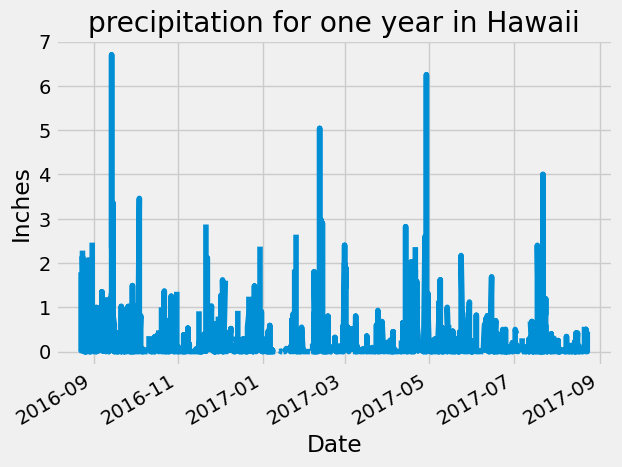

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
end_date_preformat = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0] # Date is in 0th place of the tuple
end_date = dt.datetime.strptime(end_date_preformat,'%Y-%m-%d') # Converting date to frendly format

# Calculate the date one year from the last date in data set.
# Assuming one year is 365 days (non - leap year) for time delta
start_date = end_date - dt.timedelta(days = 365)
# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp] # Sqery Terms

data = session.query(*sel).filter(Measurement.date >= '2016-08-23').all() # Preform the Query using a set date


# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(data, columns = ["date", "precipitation"])
precipitation_df["date"] = pd.to_datetime(precipitation_df["date"], format = "%Y-%m-%d")

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values(by='date',ascending=True)

# Use Pandas Plotting with Matplotlib to plot the data
# Setting the Title, X & Y labels and turing off the legend
axP= precipitation_df.plot(title = 'precipitation for one year in Hawaii',
                      x = 'date', y = 'precipitation',
                      xlabel = 'Date', ylabel = 'Inches',
                     legend = False)

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
precipitation_df['precipitation'].describe()

count    2021.000000
mean        0.177279
std         0.461190
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: precipitation, dtype: float64

# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
# Using Distinct to make sure that the count is of unqine stations
session.query(Measurement.station).distinct().count()

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

# Using the func.count to count the Number of time a station is listed in the measurement table and then ordering in descending order
station_query = [Measurement.station, func.count(Measurement.station)]
station_active = session.query(*station_query).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.station).desc())\
        .all()

station_active

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Most active station is in the first row of the previous query, assing the station ID to a variable
station_id_most_active = station_active[0][0]

# Setting query paramaters of min, max and avergage of the tempature
most_active_station_query = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]

# Preforming the query with the filter that the station is the one that was identified to be the most active
session.query(*most_active_station_query).filter(Measurement.station == station_id_most_active).all()


[(54.0, 85.0, 71.66378066378067)]

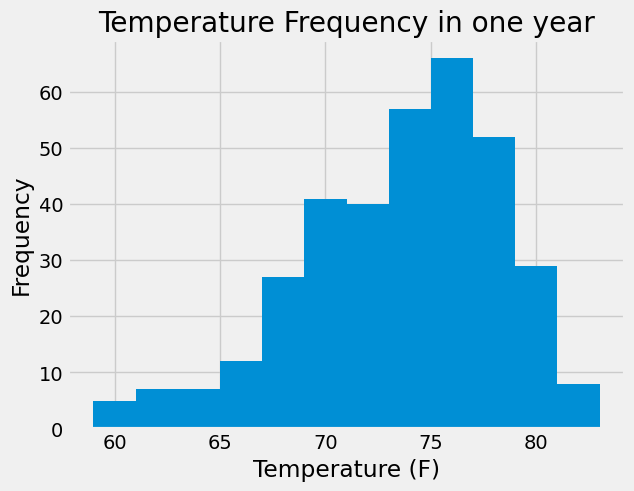

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
station_id_most_active = station_active[0][0]

# Setting query paramaters of Date and the Tempature
most_active_station_query_1 = [Measurement.date, Measurement.tobs]

# Preforming the query with the filter that the station is the one that was identified to be the most active and dates in a range
data_1 = session.query(*most_active_station_query_1).filter(Measurement.station == station_id_most_active)\
    .filter(Measurement.date >= start_date).filter(Measurement.date <= end_date)\
    .all()

# Converting the data to a Pandas Data Frame
pd_tempture = pd.DataFrame([{"Date":result[0], "Tempature":result[1]} for result in data_1])

# Setting the plotting parameters of the plot
ax = pd_tempture.plot(kind = 'hist', bins = 12,
                 title = 'Temperature Frequency in one year',
                 xlabel = 'Temperature (F)',
                 legend = False)

# Close Session

In [16]:
# Close Session
session.close()
